In [79]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# read in file
nRowsRead = 284807
df1 = pd.read_csv('C:\\Users\\ajens\\OneDrive\\Documents\\Personal\\A.Jensen MDS\\creditcard.csv\\creditcard.csv', delimiter=',', nrows= nRowsRead)
df1.dataframeName = 'Fraud Detection'

In [41]:
Class = pd.DataFrame(df1['Class'],columns=['Class'])

In [42]:
df1.drop(['Time', 'Class'], axis=1,inplace=True)

In [77]:
# transform the dataset
oversample = SMOTE()
df1, Class = oversample.fit_resample(df1, Class)

Class
0        284315
1        284315
dtype: int64


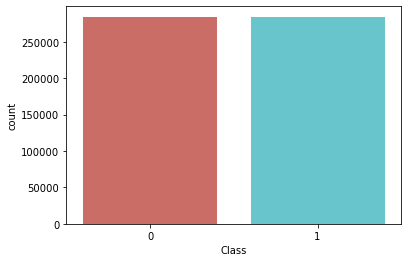

Percentage of fraudulent class: 50.0
Percentage of non-fraudulent class: 50.0


In [94]:
# Value count showing imbalanced data
print(Class.value_counts())
# Visulaize the imbalance
sns.countplot(x=Class.iloc[:,0], data=df1, palette='hls')
plt.show()
# Percentage of imbalanced data by class
not_fraud = len(Class.iloc[:,0]==0)
fraud = len(Class.iloc[:,0]==1)
pct_of_no_fraud = not_fraud/(not_fraud+fraud)
pct_of_fraud = fraud/(not_fraud+fraud)
print("Percentage of fraudulent class:", pct_of_fraud*100)
print("Percentage of non-fraudulent class:", pct_of_no_fraud *100)

Our classes are now balanced! Compare to the original EDA notebook to see the class distribution differences.

In [95]:
pipe = make_pipeline(
    MinMaxScaler(),
    GradientBoostingClassifier(random_state=42,
                             n_estimators=100,
                             verbose=False)
)
X_train, X_test, y_train, y_test = train_test_split(df1, Class, test_size=0.3, random_state=42)
pipe.fit(X_train, y_train).score(X_test, y_test)

0.9809542233086541

In [97]:
y_pred = pipe.predict(X_test)
print(pipe,"\n\nAccuracy: ",accuracy_score(y_test,y_pred)*100)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42, verbose=False))]) 

Accuracy:  98.09542233086542


As expected, the accuracy decreased compared to the imbalaced data, but only by a small margin. This gives us a better representation of our metrics now that we balanced our data. 

In [98]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))

[[84239   910]
 [ 2339 83101]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     85149
           1       0.99      0.97      0.98     85440

    accuracy                           0.98    170589
   macro avg       0.98      0.98      0.98    170589
weighted avg       0.98      0.98      0.98    170589



In [99]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN)) 
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*40)
    print(f'Accuracy: {round(conf_accuracy * 100.0,4)}%') 
    print(f'Sensitivity: {round(conf_sensitivity * 100.0,4)}%') 
    print(f'Specificity: {round(conf_specificity * 100.0,4)}%') 
    print(f'Precision: {round(conf_precision * 100.0,4)}%')
    print(f'f_1 Score: {round(conf_f1 * 100.0,4)}%')

In [100]:
confusion_metrics(confusion_matrix)

True Positives: 83101
True Negatives: 84239
False Positives: 910
False Negatives: 2339
----------------------------------------
Accuracy: 98.0954%
Sensitivity: 97.2624%
Specificity: 98.9313%
Precision: 98.9313%
f_1 Score: 98.0897%


Sensitivity (aka Recall) means out of all actual Positives, how many did we predict as Positive.

Specificity (aka Selectivity or True Negative Rate, TNR) means out of all actual Negatives, how many did we predict as Negative.

Precision (aka Positive Predictive Value, PPV) means “out of all predicted Positive cases, how many were actually Positive.

F1 Score is the harmonic, or weighted average of Precision and Sensitivity.

In [101]:
# cross validation score
scores= cross_val_score(pipe, df1, Class, cv= 10)
print(scores)
print(f'\nAverage Cross Validation score= {np.mean(scores)}')

[0.97307564 0.97961768 0.97961768 0.97910768 0.97965285 0.97905492
 0.98153457 0.98069043 0.98056733 0.98220284]

Average Cross Validation score= 0.9795121608075549


Our data ran through the pipeline with cross validation appears to perform slightly better, however, the improved performance is insignificant. 